In [1]:
import json

import altair as alt
import pandas as pd
import teammachine as tm

# Altair configuration
# Comment this line if using Jupyter Lab instead of a plain notebook
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
# Construct a teammachine Client with credentials downloaded from https://app.teammachine.io/spaces/api-clients
with open('/path/to/credentials.json') as f:
    credentials = json.load(f)
    
client = tm.Client(**credentials)

In [3]:
# Fetch a list of our code repositories
repos_query = client.code_repo
repos = repos_query.request()

# Results are nested dictionaries and lists like 
# {'CodeRepo': [{'tm_id': 'a', 'tm_display_name': 'b', 'node_type': 'CodeRepo'} ...]}}

# If you have Pandas installed, it's usually more convenient to use Pandas DataFrames
# This result set has only one DataFrame, a list of code_repos
print(repos.dataframes)

repos.dataframes.code_repo[['tm_id', 'node_type']].head()

<DataFrames: code_repo>


,tm_id,node_type
0,ghr-4OwhLW3bR6z40O,CodeRepo
1,ghr-3QWO9uRp57DB75,CodeRepo
2,ghr-3EeDhmgImKv3o,CodeRepo
3,ghr-4rj9Xts3AxQ5ye,CodeRepo
4,ghr-5aqX1Mb9IvhN37,CodeRepo


In [4]:
# Let's extend our earlier query to get the activity in each repo
# NOTE: .activity(...) creates a new Query object and does not modify 
# the "repos_query"
commits = repos_query.activity(start_date='2019-01-01').request()

# This result set now has two dataframes: a list of repos and the related activity
print(commits.dataframes)

<DataFrames: code_repo_activity, code_repo>


In [5]:
# NOTE: the dataframe names follow the names found inside the API results and nested objects
# like "created_by" are flattened
commits.dataframes.code_repo_activity.sort_values('created_at')[['code_repo_id', 'tm_id', 'created_at']].head()

,code_repo_id,tm_id,created_at
2633,ghr-2n9jkF4O9ckfrX,gic-38ziVLvYWEosOk,2019-01-01 13:42:38+00:00
2632,ghr-2n9jkF4O9ckfrX,gic-5K2VjFtdCX3Ssj,2019-01-01 13:42:48+00:00
2631,ghr-2n9jkF4O9ckfrX,gic-5RymHcc1H5dJ8f,2019-01-01 13:52:48+00:00
2630,ghr-2n9jkF4O9ckfrX,gic-1MZEIDKmGCnwEM,2019-01-01 15:34:07+00:00
2629,ghr-2n9jkF4O9ckfrX,gic-5YkPe0JVPq7Rwa,2019-01-01 15:55:28+00:00


In [9]:
# Child dataframes have references to parent objects so you can join the tables together
# Let's merge the repo and commit dataframes to get the repo names
commits_df = commits.dataframes.code_repo_activity.merge(
    # rename the columns on the repos DataFrame to avoid naming conflicts
    commits.dataframes.code_repo.rename(columns={
        'tm_id': 'code_repo_id',
        'tm_display_name': 'code_repo_name',
        'node_type': 'code_repo_node_type',
    }), 
).sort_index(axis=1)

commits_df.sort_values('created_at')[['code_repo_name', 'tm_id', 'created_at']].head()

,code_repo_name,tm_id,created_at
2633,tm-gitops,gic-38ziVLvYWEosOk,2019-01-01 13:42:38+00:00
2632,tm-gitops,gic-5K2VjFtdCX3Ssj,2019-01-01 13:42:48+00:00
2631,tm-gitops,gic-5RymHcc1H5dJ8f,2019-01-01 13:52:48+00:00
2630,tm-gitops,gic-1MZEIDKmGCnwEM,2019-01-01 15:34:07+00:00
2629,tm-gitops,gic-5YkPe0JVPq7Rwa,2019-01-01 15:55:28+00:00


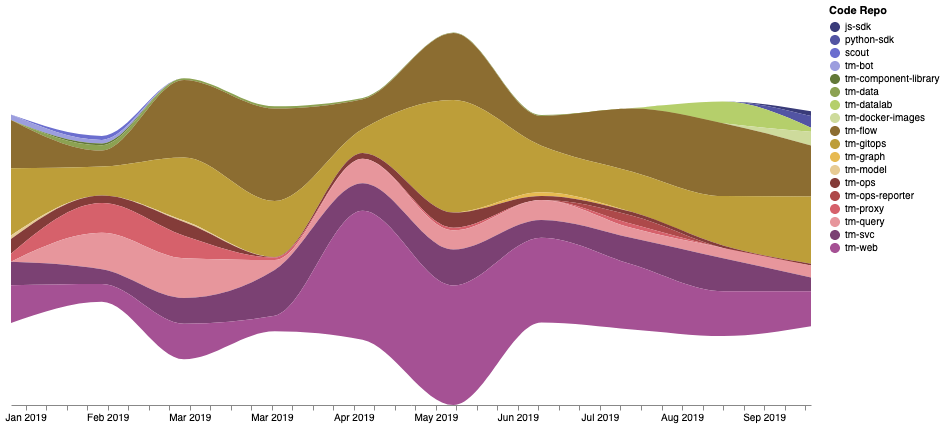

In [10]:
# Let's plot monthly activity across the code repos using altair (https://altair-viz.github.io/)

alt.Chart(
    commits_df.groupby(
        ['code_repo_name', pd.Grouper(key='created_at', freq='m')]
    ).tm_id.count().reset_index(),
    height=400,
    width=800,
).mark_area(interpolate='monotone').encode(
    x=alt.X('yearmonth(created_at):T', axis=alt.Axis(title=None)),
    y=alt.Y('tm_id:Q', stack='center', axis=None),
    color=alt.Color(
        'code_repo_name:N',
        scale=alt.Scale(scheme='category20b'),
        legend=alt.Legend(title='Code Repo'),
    ),
    tooltip=[
        alt.Tooltip('code_repo_name', title='Code Repo'),
        alt.Tooltip('yearmonth(created_at)', title='Month'),
        alt.Tooltip('tm_id', title='Commits'),
    ]
).configure_axis(grid=False).configure_view(strokeWidth=0)